# Functional Connectivity Second Level Analysis
Load group connectivity maps and run statistical analyses
1. Test for statistical significance of correlation maps (Is the connectivity strength significantly different from zero?)
2. Test for difference between maps of different ROIs
3. Save t-test map
4. Save significant clusters as labels - this is done manually in Freeview
5. Load clusters, extract correlation values from group map and save as dataframe
6. calculate correlations between connectivity values and reading scores

In [1]:
# Compare and analyze seed-based connectivity maps
# import
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
import glob
import os
import nilearn
#import scipy as scp
from nilearn import signal
from scipy import stats
import nibabel as nib
from os.path import exists
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import platform
dataset = 'HBN'
if dataset == 'HBN':
    if platform.system() == "Darwin":
        projectdir = '/Volumes/GoogleDrive/My Drive/Projects/HBN/HBN_FC/'
        # Paths to surface ROIs from Emily
        roidir =  '/Users/mayayablonski/Documents/Data/FC/ROIs'
    elif platform.system() == "Linux":
        projectdir = '/scratch/groups/jyeatman/HBN_FC/'
        # Paths to surface ROIs from Emily
        roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/'
elif dataset == 'LMB':
    projectdir = '/scratch/groups/jyeatman/LMB_Connectivity/'
    
print(projectdir)

/scratch/groups/jyeatman/HBN_FC/


In [5]:
# Define paths:
space = 'surface' # volume or surface analysis
datadir = projectdir + space + '/statMaps/'
analysesdir = projectdir + space + '/analyses/'

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage',data_dir = '/home/groups/jyeatman/software')

# Load LH surface to get its size
white_left = surface.load_surf_data(fsaverage['white_left'])
# Load RH surface to get its size
white_right = surface.load_surf_data(fsaverage['white_right'])

# Paths to surface ROIs from Emily:
roi_names = ['MPM_lh_IOS.label','lh_pOTS_chars.label','lh_mOTS_chars.label','lh_IFS_S_chars.label']
#roi_names = ['lh_pOTS_chars.label','lh_mOTS_chars.label']
# the IOS ROI is a character selective ROI from Rosenke 2021, looks like OWFA

if space == 'volume':
# ROIs from volume analysis (transformed to the surface)
    roi_names = ['VWFA1','VWFA2']
Faces = False
if Faces == True:
    roi_names = ['lh_pFus_faces.label','lh_mFus_faces.label']
    datadir = datadir + 'Faces/'
    analysesdir = analysesdir + 'Faces/'
    
# Parameters for current run:
task = 'rest' # options are 'rest', 'movie'
saveFigures = False
hemi = 'left'

In [6]:
# silly loop to rename roi names for plotting, we want to keep the long names to locate their files
roi_short_names = roi_names.copy()
for roi_i in range(len(roi_names)):
    if "IOS" in roi_names[roi_i]:
        roi_short_names[roi_i] = "IOS"
    if "mOTS" in roi_names[roi_i]:
        roi_short_names[roi_i] = "mOTS"
    if "pOTS" in roi_names[roi_i]:
        roi_short_names[roi_i] = "pOTS"
    if "IFS" in roi_names[roi_i]:
        roi_short_names[roi_i] = "IFS"
    if "pFus" in roi_names[roi_i]:
        roi_short_names[roi_i] = "pFus"
    if "mFus" in roi_names[roi_i]:
        roi_short_names[roi_i] = "mFus"

print(roi_names)
print(roi_short_names)    

['MPM_lh_IOS.label', 'lh_pOTS_chars.label', 'lh_mOTS_chars.label', 'lh_IFS_S_chars.label']
['IOS', 'pOTS', 'mOTS', 'IFS']


In [7]:
# Load curated behavioral data
if dataset == 'HBN':
    subject_file = projectdir + 'subs_preprocessed_restingstate_movieDM_meanFD05_SNR15_FD05_90_WIAT_FilteredAfterScrubbing_0.5_0.2.csv'
    if task == 'rest':
        subject_file = projectdir+ 'subs_preprocessed_onlyrest_meanFD05_SNR15_FD05_90_WIAT.csv'
    elif task == 'movie':
        subject_file = projectdir+ 'subs_preprocessed_onlymovie_meanFD05_SNR15_FD05_90_WIAT.csv'

    sub_data = pd.read_csv(subject_file)
    subs = sub_data['participant_id']

sub_count = len(subs)
print(sub_count)

224


In [9]:
# First we load all seed-based connectivity maps that were pre-saved by HBN_FC.py
if hemi == 'left':
    roi_maps = np.zeros(shape = (sub_count,white_left[0].shape[0],len(roi_names)))
    #roi_map shape is subjects * vertices * seed
else:
    roi_maps = np.zeros(shape = (sub_count,white_right[0].shape[0],len(roi_names)))

# Load all data into one array
for roi_i in range(len(roi_names)):
    cur_roi_path = datadir + 'GroupMap_task-' + task + '_' + roi_names[roi_i] + '_N' + str(sub_count)+ '_fisherz_' + hemi[0] + 'h.npy'
    print('Loading ' + cur_roi_path)
    cur_roi_map = np.load(cur_roi_path)
    cur_roi_mean = np.nanmean(cur_roi_map,axis=0)
    roi_maps[:,:,roi_i] = cur_roi_map
 

Loading /scratch/groups/jyeatman/HBN_FC/surface/statMaps/GroupMap_task-rest_MPM_lh_IOS.label_N224_fisherz_lh.npy
Loading /scratch/groups/jyeatman/HBN_FC/surface/statMaps/GroupMap_task-rest_lh_pOTS_chars.label_N224_fisherz_lh.npy
Loading /scratch/groups/jyeatman/HBN_FC/surface/statMaps/GroupMap_task-rest_lh_mOTS_chars.label_N224_fisherz_lh.npy
Loading /scratch/groups/jyeatman/HBN_FC/surface/statMaps/GroupMap_task-rest_lh_IFS_S_chars.label_N224_fisherz_lh.npy


### Plot seed-based connectivity

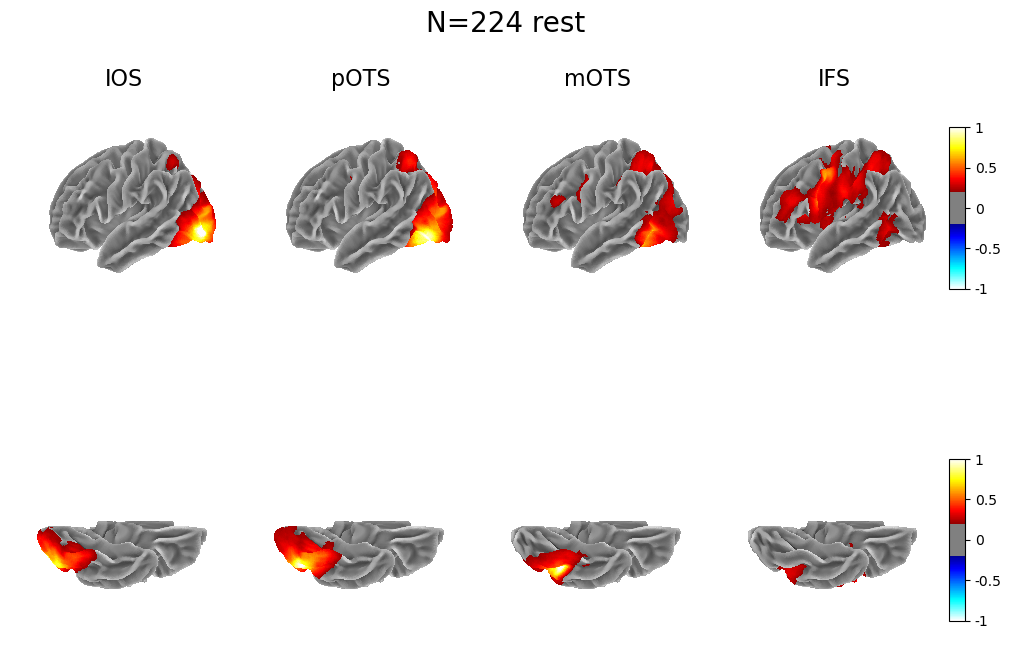

In [24]:
# Plot mean group connectivity maps
# create main Figure
#fig, axes = plt.subplots(2,len(roi_names),figsize=(10,4),sharey=True,subplot_kw={'projection': '3d'})
fig, axes = plt.subplots(2,len(roi_names),figsize=(10,7),subplot_kw={'projection': '3d'},constrained_layout=True)
#fig.tight_layout(pad=0, w_pad=0, h_pad=0)
#fig.constrained_layout()

for roi_i in range(len(roi_names)):
    # plot mean group connectivity for each seed ROI
    cur_roi_map = roi_maps[:,:,roi_i]
    cur_roi_mean = np.nanmean(cur_roi_map,axis=0)
    
    if roi_i == (len(roi_names)-1):
        do_cb=True
    else:
        do_cb=False
        
    plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=cur_roi_mean,
    hemi=hemi, threshold = .2, vmax=1, view='lateral', colorbar=do_cb,axes=axes[0,roi_i],
    bg_map=fsaverage['curv_' + hemi],title=None, output_file = None)
    axes[0,roi_i].set_title(roi_short_names[roi_i],fontsize=16)
    
    plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=cur_roi_mean,
    hemi=hemi, threshold = .2, vmax=1, view='ventral', colorbar=do_cb,axes=axes[1,roi_i],
    bg_map=fsaverage['curv_'+ hemi],title=None, output_file = None)
    #axes[1,roi_i].set_title(roi_names[roi_i]) # we dont need extra titles in the second row

   # This inteactive plots doesn't work in a loop
   # plotting.view_surf(fsaverage['white_left'], surf_map=cur_roi_mean,
   # threshold = .15, vmax=1, colorbar=True,
   # bg_map=fsaverage['curv_left'],title='Group map N=' + str(sub_count) + ' ' + roi_names[roi_i])

fig.suptitle('N=' + str(sub_count) + ' ' + task,fontsize=20)
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0,hspace=0.2) # this fixes the titles but messes up the colorbars

if saveFigures:
    figurename = analysesdir + 'GroupMean_N' + str(sub_count) + '_' + task + '_' + hemi
    fig.savefig(figurename + '.png')

### Test for group-level significance of seed-based correlation maps for each ROI
This is done by a 1-sample t-test: is the population mean of R-values in this vertex significanly different from zero?

In [25]:
print(white_left[0].shape)
print(white_right[0].shape)
print(cur_roi_mean.shape)
bg_left = surface.load_surf_data(fsaverage['curv_left'])
print(bg_left.shape)

(163842, 3)
(163842, 3)
(163842,)
(163842,)


/scratch/groups/jyeatman/HBN_FC/surface/statMaps/T1-test_movie_N120_IOS_rh.curv
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/T1-testZ_movie_N120_IOS_rh.curv
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/T1-test_movie_N120_pOTS_rh.curv
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/T1-testZ_movie_N120_pOTS_rh.curv
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/T1-test_movie_N120_mOTS_rh.curv
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/T1-testZ_movie_N120_mOTS_rh.curv
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/T1-test_movie_N120_IFS_rh.curv
/scratch/groups/jyeatman/HBN_FC/surface/statMaps/T1-testZ_movie_N120_IFS_rh.curv


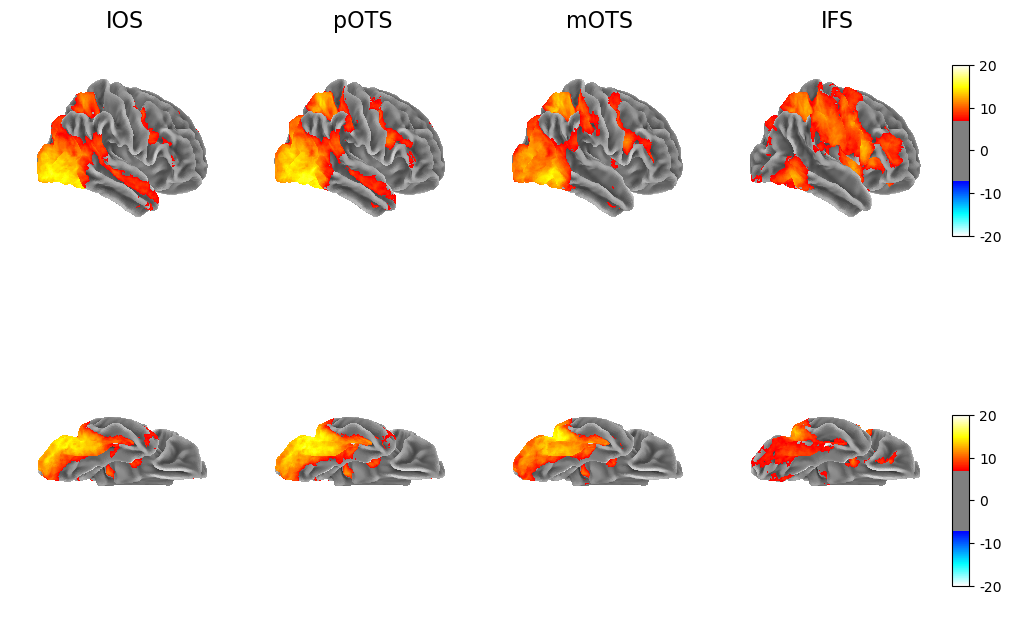

In [42]:
# create Figure
r_fig, r_axes = plt.subplots(2,len(roi_names),figsize=(10,7),subplot_kw={'projection': '3d'},constrained_layout=True)

if dataset == 'HBN':
    threshold = 7
    vmax=20
elif dataset == 'LMB':
    threshold = 3.5
    vmax=10
    
for roi_i in range(len(roi_names)):
    cur_roi_map = roi_maps[:,:,roi_i]
    t_vals, p_vals = stats.ttest_1samp(cur_roi_map, 0)
    z_vals = stats.norm.isf(p_vals)
    # I am not sure why we are plotting z_vals rather than t_vals. I followed this tutorial:
    # https://nilearn.github.io/stable/auto_examples/07_advanced/plot_surface_bids_analysis.html#sphx-glr-auto-examples-07-advanced-plot-surface-bids-analysis-py
    # Plot
    
    if roi_i == (len(roi_names)-1):
        do_cb=True
    else:
        do_cb=False
        
    plotting.plot_surf_stat_map(fsaverage['white_'+ hemi], stat_map=z_vals,
    hemi=hemi, threshold = threshold, vmax=vmax, view='lateral', colorbar=do_cb,axes=r_axes[0,roi_i],
    bg_map=fsaverage['curv_' + hemi],title=None)
    r_axes[0,roi_i].set_title(roi_short_names[roi_i],fontsize=16)

    plotting.plot_surf_stat_map(fsaverage['white_'+ hemi], stat_map=z_vals,
    hemi=hemi, threshold = threshold, vmax=vmax, view='ventral', colorbar=do_cb,axes=r_axes[1,roi_i],
    bg_map=fsaverage['curv_' + hemi],title=None)
    
    tmap_fileName = f'{datadir}T1-test_{task}_N{sub_count}_{roi_short_names[roi_i]}_{hemi[0]}h.curv'
    print(tmap_fileName)
    nib.freesurfer.io.write_morph_data(tmap_fileName,t_vals)
    
    zmap_fileName = f'{datadir}T1-testZ_{task}_N{sub_count}_{roi_short_names[roi_i]}_{hemi[0]}h.curv'
    print(zmap_fileName)
    nib.freesurfer.io.write_morph_data(zmap_fileName,z_vals)


# set the spacing between subplots
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.2, 
#                     top=0.2, 
#                     wspace=0.4, 
#                     hspace=0.4)
# FIXME - subtitles are cut off and background is transparent
# Looks like the colorbars are a different axis.
# find a way to fix spacing between plots and plot only a single colorbar at the right
if saveFigures:
    figurename = analysesdir + 'Group_TtestROIs_N' + str(sub_count) + '_' + task + '_' + hemi
    r_fig.savefig(figurename + '.png')

### Test for difference between seed-based maps
This is done by a 2-sample paired t-test: is the difference between r-values in each vertex significantly different from zero accross participants?

In [7]:
# Calculate thresh for visualization
p_threshold = 0.0000000001
t_threshold = stats.t.isf(p_threshold/2, sub_count-1)
print(t_threshold)
#verify
# sf-> survival function; isf -> inverse survival function
print(stats.t.sf(t_threshold, sub_count-1)*2)

6.790554675436402
1.0000000000060364e-10


In [41]:
# Run a dependent sample t-test between the two maps
roi1_ind = roi_short_names.index('pOTS')
roi2_ind = roi_short_names.index('mOTS')
ttest_res = stats.ttest_rel(roi_maps[:,:,roi1_ind],roi_maps[:,:,roi2_ind],nan_policy='omit')
if saveFigures:
    figurename = analysesdir + 'Group_Ttest_N' + str(sub_count) + '_' +roi_short_names[roi1_ind] + '_' + roi_short_names[roi2_ind]+ '_' + task + '_' + hemi
    titlename = None
else:
    figurename = None
    titlename = 'T-test '+ roi_short_names[roi1_ind] + ' - ' + roi_short_names[roi2_ind] + ' ' + task
# Plot t-test result as a map
plotting.plot_surf_stat_map(fsaverage['white_'+ hemi], stat_map=ttest_res.statistic,
hemi=hemi, threshold = t_threshold, vmax=vmax, view='lateral', colorbar=True,
bg_map=fsaverage['curv_'+hemi], title=titlename, output_file = figurename + '_lateral')
print()
#figurename = analysesdir + 'Group_Ttest_N' + str(sub_count) + roi_names[roi1_ind] + ' - ' + roi_names[roi2_ind]+'_' + task + '_' + hemi
#plt.savefig(figurename + '.png')
plotting.plot_surf_stat_map(fsaverage['white_'+ hemi], stat_map=ttest_res.statistic,
hemi=hemi, threshold = t_threshold, vmax=vmax, view='ventral', colorbar=True,
bg_map=fsaverage['curv_'+ hemi], title=titlename, output_file = figurename + '_ventral')
print()

# Plot the difference between the ROIs as a map
mean_diff = np.mean((roi_maps[:,:,roi1_ind]-roi_maps[:,:,roi2_ind]),axis=0)
plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=mean_diff,
hemi=hemi, threshold = 0.05, vmax=1, view='lateral', colorbar=True,
bg_map=fsaverage['curv_'+hemi], title='Subtraction '+ roi_short_names[roi1_ind] + ' - ' + roi_short_names[roi2_ind] + ' ' + task, output_file = None)
print()


In [31]:
# syntax for interactive viewing
view = plotting.view_surf(fsaverage['white_left'], surf_map=ttest_res.statistic,
threshold = t_threshold, vmax=15, colorbar=True,
bg_map=fsaverage['curv_left'],title='pOTS-mOTS')

view
view.save_as_html(analysesdir + 'GroupMap_task-' + task + '_N_'+ str(sub_count)+ '_ttest_view_' + hemi + '_thresh_'+ str(round(t_threshold, 2)))

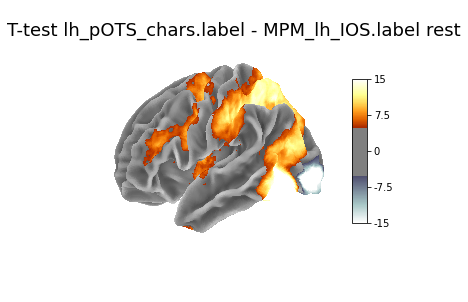

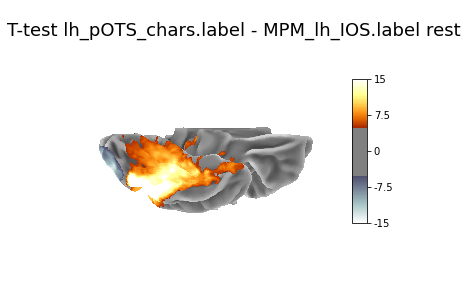

In [32]:
# Same for IOS and pOTS
# Run a dependent sample t-test between the two maps
roi1_ind = roi_short_names.index('pOTS')
roi2_ind = roi_short_names.index('IOS')
ttest_res = stats.ttest_rel(roi_maps[:,:,roi1_ind],roi_maps[:,:,roi2_ind],nan_policy='omit')
# Plot t-test result as a map
plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=ttest_res.statistic,
hemi='left', threshold = t_threshold, vmax=15, view='lateral', colorbar=True,cmap='hot_black_bone_r',
bg_map=fsaverage['curv_left'], title='T-test '+ roi_short_names[roi1_ind] + ' - ' + roi_short_names[roi2_ind] + ' ' + task, output_file = None)
print()
plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=ttest_res.statistic,
hemi='left', threshold = t_threshold, vmax=15, view='ventral', colorbar=True,cmap='hot_black_bone_r',
bg_map=fsaverage['curv_left'], title='T-test '+ roi_short_names[roi1_ind] + ' - ' + roi_short_names[roi2_ind] + ' ' + task, output_file = None)
print()

In [9]:
# save this t-test map as a gii and open in freeview for labeling clusters manually
roi1_ind = roi_short_names.index('pOTS')
roi2_ind = roi_short_names.index('mOTS')
if faces = True:
    roi1_ind = roi_short_names.index('pFus')
    roi2_ind = roi_short_names.index('mFus')
    
ttest_res = stats.ttest_rel(roi_maps[:,:,roi1_ind],roi_maps[:,:,roi2_ind],nan_policy='omit')
# MAKE SURE YOU ARE USING THE RIGHT ROI INDICES!
tmap_fileName = f'{datadir}ttest_{task}_N{sub_count}_{roi_short_names[roi1_ind]}_{roi_short_names[roi2_ind]}_{hemi[0]}h.curv'
print(tmap_fileName)
nib.freesurfer.io.write_morph_data(tmap_fileName,ttest_res.statistic)

/scratch/groups/jyeatman/HBN_FC/surface/statMaps/Faces/ttest_rest_N224_pFus_mFus_lh.curv


# Test correlations with fronal ROI vs behavior
### Use Group average frontal IFS ROI instead of the t-test cluster

In [34]:
# Create a dataframe with connectivity values extracted from each subject for each seed
# Clusters here are group average ROIs
if hemi == 'left':
    roi_map = np.zeros(white_left[0].shape[0])
elif hemi == 'right':
    roi_map = np.zeros(white_right[0].shape[0])
    
roi_df = pd.DataFrame()

clusters = ['lh_IFS_S_chars.label']
#clusters = roi_names

# loop through all seed ROI + cluster combinations
for roi_i in range(len(roi_names)):
    for cluster_i in range(len(clusters)):  
        cluster_name = os.path.splitext(clusters[cluster_i])[0]
        cur_cluster = surface.load_surf_data(roidir + clusters[cluster_i])
        # color the cluster so we can plot them in one map
        roi_map[cur_cluster] = cluster_i+1
        # Extract values from group correlation map
        roi_r_vals = np.nanmean(roi_maps[:,cur_cluster,roi_i], axis=1)
      #  print(roi_r_vals.shape)
        roi_df[roi_short_names[roi_i]+ '_' +cluster_name] = roi_r_vals 


In [35]:
roi_df.describe()

,IOS_lh_IFS_S_chars,pOTS_lh_IFS_S_chars,mOTS_lh_IFS_S_chars,IFS_lh_IFS_S_chars
count,224.000000,224.000000,224.000000,224.000000
mean,0.052359,0.126514,0.232881,0.618251
std,0.098932,0.109763,0.118135,0.106176
min,-0.214128,-0.134840,-0.045160,0.349276
25%,-0.019520,0.045239,0.155413,0.550776
50%,0.046178,0.124093,0.219171,0.610895
75%,0.117459,0.187677,0.305838,0.685219
max,0.394938,0.497394,0.534995,0.947268


In [36]:
roi_df = roi_df[['pOTS_lh_IFS_S_chars','mOTS_lh_IFS_S_chars']]
roi_df

,pOTS_lh_IFS_S_chars,mOTS_lh_IFS_S_chars
0,0.123421,0.101546
1,0.354878,0.435244
2,0.171641,0.183391
3,-0.051726,0.108726
4,0.182749,0.161676
...,...,...
219,0.027726,0.052529
220,-0.009594,0.155191
221,0.286887,0.307242
222,0.054140,0.408277


In [37]:
roi_df['Delta'] =  roi_df.apply(lambda row: row['mOTS_lh_IFS_S_chars'] - row['pOTS_lh_IFS_S_chars'], axis = 1)
#roi_df_long = roi_df.melt(id_vars=['sub','Delta'],value_vars=['VWFA-1_IFS','VWFA-2_IFS'],var_name='IFS_ROI',value_name = 'FC',ignore_index=True)
#roi_df_long
roi_df.describe()

,pOTS_lh_IFS_S_chars,mOTS_lh_IFS_S_chars,Delta
count,224.000000,224.000000,224.000000
mean,0.126514,0.232881,0.106367
std,0.109763,0.118135,0.104113
min,-0.134840,-0.045160,-0.254595
25%,0.045239,0.155413,0.035050
50%,0.124093,0.219171,0.100272
75%,0.187677,0.305838,0.163569
max,0.497394,0.534995,0.464248


In [ ]:
#This repeats the same analysis of the ROI to ROI script
fig, ax = plt.subplots(figsize =(4, 3))
sns.violinplot(data=plot_data_long,x='IFS_ROI',y='FC',color='lightgray',legend=False, linewidth=0)
sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',hue='Delta',errorbar=('ci',95),palette='viridis',legend=False,markers='o',linewidth=0.5,size=0.5)
ax.get_legend().remove()
plt.ylabel('Connectivity\n(z-score)',fontsize=14,fontname='Helvetica')
plt.xlabel('')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [38]:
# merge behavioral df with brain df so we can filter them together
roi_df['participant_id'] = sub_data['participant_id']
all_df = pd.merge(sub_data,roi_df,how='outer', on='participant_id')

N = 224(WIAT_Word_Raw vs pOTS_lh_IFS_S_chars)
N = 224(WIAT_Word_Raw vs mOTS_lh_IFS_S_chars)


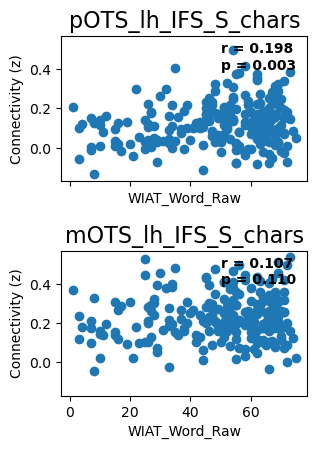

In [78]:
# plot reading against correlation values from significant clusters
myVar = 'TOWRE_Total_Scaled' # options are WIAT_Word_Stnd, WIAT_Word_Raw, Age
myData = sub_data[myVar]

roi1_ind = roi_short_names.index('pOTS')
roi2_ind = roi_short_names.index('mOTS')
roi_columns = roi_short_names[roi1_ind:roi2_ind+1]

#scat_fig, scat_axes = plt.subplots(len(roi_names),len(clusters),figsize=(20,10),sharey=True,sharex=True)
scat_fig, scat_axes = plt.subplots(len(roi_columns),len(clusters),figsize=(3,4),sharey=True,sharex=True)
scat_fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=4.0)
# remove the 'label' so can find in dataframe
clusters = [s.strip('.label') for s in clusters]
clusters = [hemi[0] + s for s in clusters]


for roi_i in range(len(roi_columns)):
    for cluster_i in range(len(clusters)):
        cluster_name = os.path.splitext(clusters[cluster_i])[0]
        cur_col = [col for col in roi_df.columns if cluster_name in col and roi_columns[roi_i] in col]
        if bool(cur_col):
            cor_val, p_val = stats.pearsonr(myData[~myData.isna()],roi_df.loc[:,cur_col][~myData.isna()])
            print('N = ' + str(len(myData[~myData.isna()])) + '(' + myVar + ' vs ' +cur_col[0]+ ')')
            #plt.annotate("r = {:.3f}".format(cor_val), (0, 1))
            if myVar == 'Age':
                xpos = 8
            else:
                xpos = 50
            if len(scat_axes.shape) >1 :
                scat_axes[roi_i,cluster_i].scatter(myData,roi_df.loc[:,cur_col])
                scat_axes[roi_i,cluster_i].set_xlabel(myVar)#,fontsize=14)
                scat_axes[roi_i,cluster_i].set_ylabel('Connectivity (z)')#,fontsize=14)
                scat_axes[roi_i,cluster_i].text(xpos, 0.4, "r = {:.3f}\np = {:.3f}".format(cor_val[0],p_val), horizontalalignment='left', size='medium', weight='semibold')
                scat_axes[roi_i,cluster_i].set_title(cur_col[0],fontsize=16)
            else:
                scat_axes[roi_i].scatter(myData,roi_df.loc[:,cur_col])
                scat_axes[roi_i].set_xlabel(myVar)#,fontsize=14)
                scat_axes[roi_i].set_ylabel('Connectivity (z)')#,fontsize=14)
                scat_axes[roi_i].text(xpos, 0.4, "r = {:.3f}\np = {:.3f}".format(cor_val[0],p_val), horizontalalignment='left', size='medium', weight='semibold')
                scat_axes[roi_i].set_title(cur_col[0],fontsize=16)

In [3]:
all_df.head()

NameError: name 'all_df' is not defined

# Previous analysis with clusters defined by t-test

In [15]:
# I opened this curv file as an overlay in Freeview
# saved the clusters manually as labels
# I have multiple versions for different thresholds saved in separate subfolders
thresh = 68 #638
cluster_dir = projectdir + 'ROIs/rest_ttest_N'+str(sub_count)+'_thresh'+str(thresh) + '/'
clusters = glob.glob(cluster_dir + '*.label')
clusters = [os.path.basename(x) for x in glob.glob(cluster_dir + '*.label')]
print(clusters)
# To pick a subset of clusters:
#clusters = ['LeftFrontal.label','LeftIFGtri.label']

['LeftSFG.label', 'LeftOFC.label', 'LeftIFGOp.label', 'LeftIFGtri.label', 'LeftFrontal.label']


In [34]:
# Create a dataframe with connectivity values extracted from each subject for each seed
roi_map = np.zeros(white_left[0].shape[0])
roi_df = pd.DataFrame()

# loop through all seed ROI + cluster combinations
for roi_i in range(len(roi_names)):
    for cluster_i in range(len(clusters)):  
        cluster_name = os.path.splitext(clusters[cluster_i])[0]
        cur_cluster = surface.load_surf_data(cluster_dir + clusters[cluster_i])
        # color the cluster so we can plot them in one map
        roi_map[cur_cluster] = cluster_i+1
        # Extract values from group correlation map
        roi_r_vals = np.nanmean(roi_maps[:,cur_cluster,roi_i], axis=1)
      #  print(roi_r_vals.shape)
        roi_df[roi_short_names[roi_i]+ '_' +cluster_name] = roi_r_vals 


In [35]:
roi_df

,IOS_LeftFrontal,IOS_LeftIFGtri,pOTS_LeftFrontal,pOTS_LeftIFGtri,mOTS_LeftFrontal,mOTS_LeftIFGtri
0,0.000006,-0.035751,-0.032467,-0.086203,0.124518,0.202654
1,-0.003389,-0.047784,0.167052,0.053853,0.197337,0.051907
2,0.066908,0.048320,0.121692,0.076868,0.217719,0.196065
3,-0.070179,-0.090551,-0.050205,-0.055850,0.149775,0.202131
4,0.152079,0.138995,0.204730,0.195966,0.264306,0.326140
...,...,...,...,...,...,...
219,-0.059546,-0.013999,0.028359,0.074102,0.053677,0.105880
220,-0.059499,-0.051926,-0.007212,-0.007111,0.089702,0.038007
221,-0.030603,-0.084949,0.164182,0.109559,0.206706,0.147719
222,0.057548,0.107603,0.075709,0.067640,0.281013,0.177072


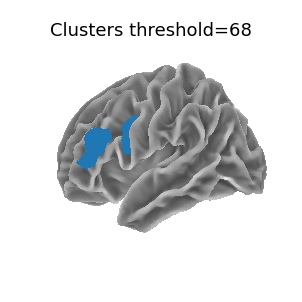

In [29]:
# Plot the clusters as a label atlas
plotting.plot_surf_roi(surf_mesh=fsaverage['white_left'], roi_map=roi_map,
threshold = 0.00001, vmax=10, colorbar=False,cmap = 'Paired',
bg_map=fsaverage['curv_left'], title='Clusters threshold=' + str(thresh))
print()

In [49]:
df_filename = analysesdir + 'ClusterMean_FisherVals_' + 'N' + str(sub_count) + '_' + task + '_ttest_thresh'+str(thresh)
roi_df.to_csv(df_filename+ '.csv')

<AxesSubplot:>

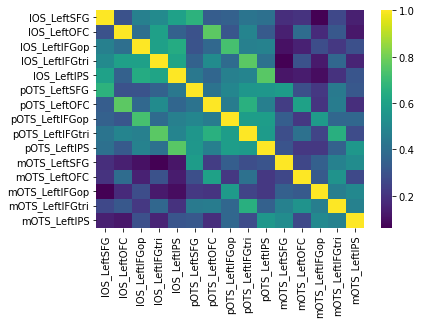

In [51]:
# plot intercorrelations between connectivity values
corrmat = roi_df.corr()
#corrmat.style.background_gradient(cmap='coolwarm') # This is another nice way to plot the correlation matrix
#but the seaborn way is prettier
sns.heatmap(corrmat,cmap='viridis')

In [5]:
# syntax to find index of specific subject
sub_data.index[sub_data['participant_id']=='sub-NDARFB506UJ3'].tolist()

[51]

In [36]:
# merge behavioral df with brain df so we can filter them together
roi_df['participant_id'] = sub_data['participant_id']
all_df = pd.merge(sub_data,roi_df,how='outer', on='participant_id')

N = 224(Age vs IOS_LeftFrontal)
N = 224(Age vs IOS_LeftIFGtri)
N = 224(Age vs pOTS_LeftFrontal)
N = 224(Age vs pOTS_LeftIFGtri)
N = 224(Age vs mOTS_LeftFrontal)
N = 224(Age vs mOTS_LeftIFGtri)


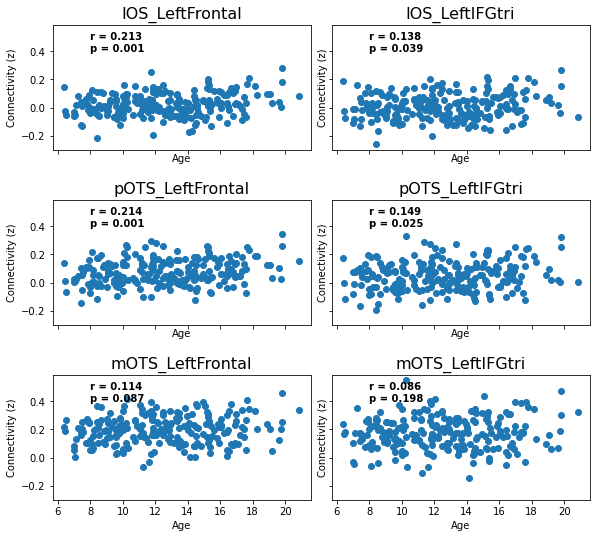

In [39]:
# plot reading against correlation values from significant clusters
myVar = 'Age' # options are WIAT_Word_Stnd, WIAT_Word_Raw, Age
myData = sub_data[myVar]
#scat_fig, scat_axes = plt.subplots(len(roi_names),len(clusters),figsize=(20,10),sharey=True,sharex=True)
scat_fig, scat_axes = plt.subplots(len(roi_names),len(clusters),figsize=(8,7),sharey=True,sharex=True)
scat_fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=4.0)
for roi_i in range(len(roi_names)):
    for cluster_i in range(len(clusters)):
        cluster_name = os.path.splitext(clusters[cluster_i])[0]
        cur_col = [col for col in roi_df.columns if cluster_name in col and roi_short_names[roi_i] in col]
        scat_axes[roi_i,cluster_i].scatter(myData,roi_df.loc[:,cur_col])
        scat_axes[roi_i,cluster_i].set_xlabel(myVar)#,fontsize=14)
        scat_axes[roi_i,cluster_i].set_ylabel('Connectivity (z)')#,fontsize=14)
        cor_val, p_val = stats.pearsonr(myData[~myData.isna()],roi_df.loc[:,cur_col][~myData.isna()])
        print('N = ' + str(len(myData[~myData.isna()])) + '(' + myVar + ' vs ' +cur_col[0]+ ')')
        #plt.annotate("r = {:.3f}".format(cor_val), (0, 1))
        if myVar == 'Age':
            xpos = 8
        else:
            xpos = 50
        scat_axes[roi_i,cluster_i].text(xpos, 0.4, "r = {:.3f}\np = {:.3f}".format(cor_val[0],p_val), horizontalalignment='left', size='medium', weight='semibold')
        scat_axes[roi_i,cluster_i].set_title(cur_col[0],fontsize=16)

In [54]:
all_df['VWFA1-VWFA2'] = all_df['pOTS_LeftFrontal']-all_df['mOTS_LeftFrontal']
print(all_df['VWFA1-VWFA2'])

0.09339895507992228 0.16359140590990798


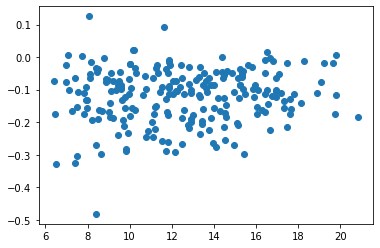

In [56]:
plt.scatter(all_df['Age'],all_df['VWFA1-VWFA2'])
cor_val, p_val = stats.pearsonr(all_df['Age'],all_df['VWFA1-VWFA2'])
print(cor_val,p_val)
plt.scatter(all_df['WIAT_Word_Stnd'],all_df['VWFA1-VWFA2'])
cor_val, p_val = stats.pearsonr(all_df['WIAT_Word_Stnd'],all_df['VWFA1-VWFA2'])
print(cor_val,p_val)

N = 224(EHQ_Total vs IOS_LeftFrontal)
N = 224(EHQ_Total vs IOS_LeftIFGtri)
N = 224(EHQ_Total vs pOTS_LeftFrontal)
N = 224(EHQ_Total vs pOTS_LeftIFGtri)
N = 224(EHQ_Total vs mOTS_LeftFrontal)
N = 224(EHQ_Total vs mOTS_LeftIFGtri)


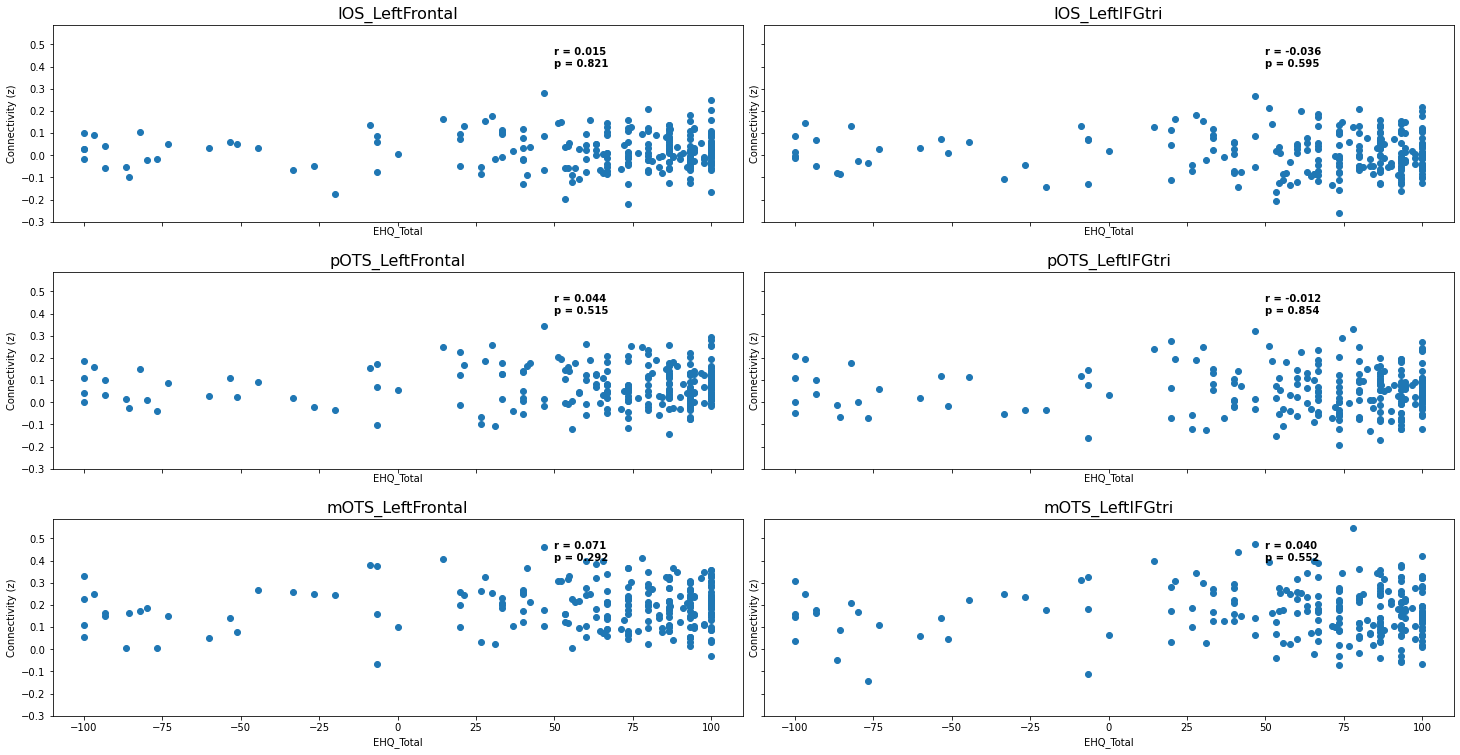

In [59]:
# plot reading against correlation values from significant clusters
myVar = 'EHQ_Total' # options are WIAT_Word_Stnd, WIAT_Word_Raw, Age
myData = all_df[myVar]
scat_fig, scat_axes = plt.subplots(len(roi_names),len(clusters),figsize=(20,10),sharey=True,sharex=True)
scat_fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=4.0)
for roi_i in range(len(roi_names)):
    for cluster_i in range(len(clusters)):
        cluster_name = os.path.splitext(clusters[cluster_i])[0]
        cur_col = [col for col in roi_df.columns if cluster_name in col and roi_short_names[roi_i] in col]
        scat_axes[roi_i,cluster_i].scatter(all_df[myVar],all_df.loc[:,cur_col])
        scat_axes[roi_i,cluster_i].set_xlabel(myVar)#,fontsize=14)
        scat_axes[roi_i,cluster_i].set_ylabel('Connectivity (z)')#,fontsize=14)
        cor_val, p_val = stats.pearsonr(myData[~all_df[myVar].isna()],all_df.loc[:,cur_col][~all_df[myVar].isna()])
        print('N = ' + str(len(myData[~myData.isna()])) + '(' + myVar + ' vs ' +cur_col[0]+ ')')
        #plt.annotate("r = {:.3f}".format(cor_val), (0, 1))
        if myVar == 'Age':
            xpos = 8
        else:
            xpos = 50
        scat_axes[roi_i,cluster_i].text(xpos, 0.4, "r = {:.3f}\np = {:.3f}".format(cor_val[0],p_val), horizontalalignment='left', size='medium', weight='semibold')
        scat_axes[roi_i,cluster_i].set_title(cur_col[0],fontsize=16)

In [62]:
all_df
df_filename = '/scratch/groups/jyeatman/HBN_FC/surface/analyses/ClusterMean_correlations_N224_rest_ttest_thresh68_LeftFrontal_Flux'
all_df.to_csv(df_filename+ '.csv')

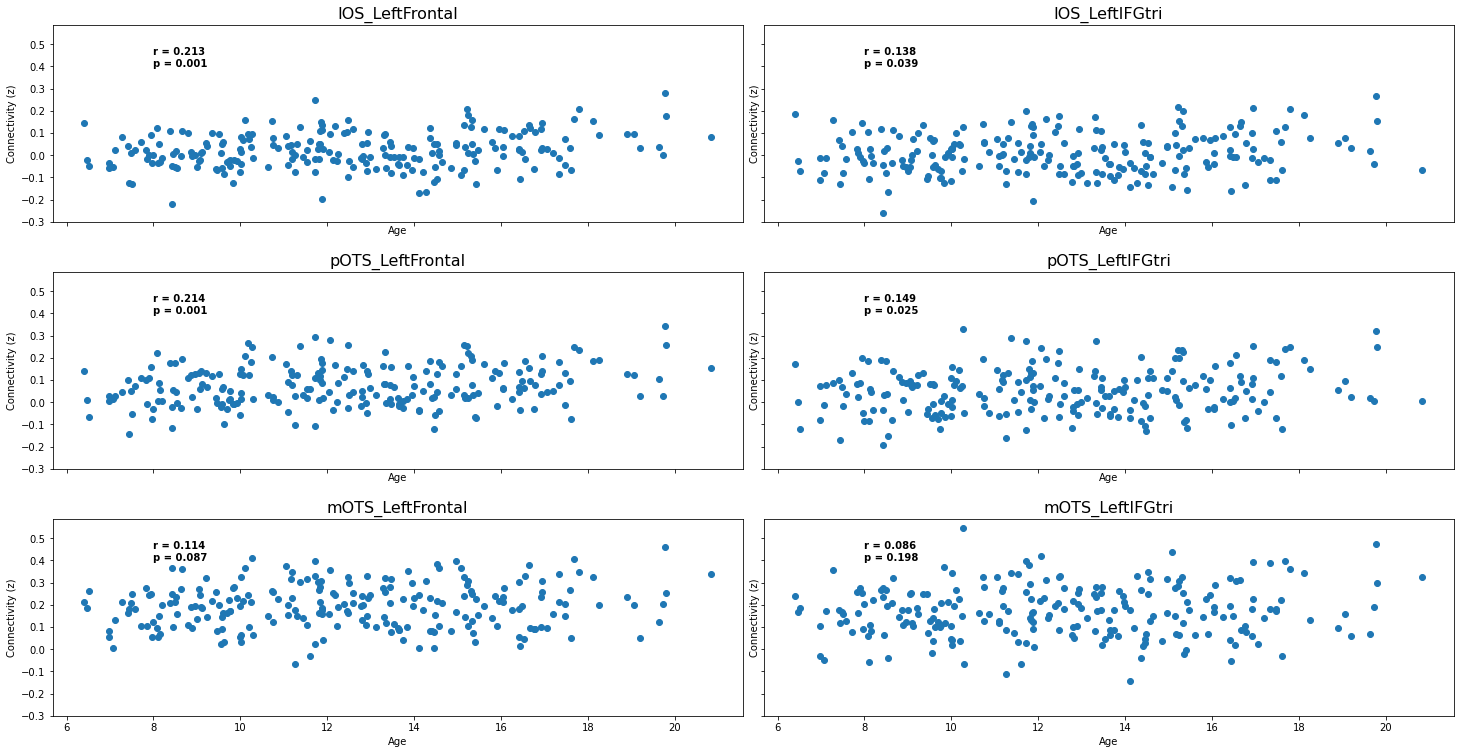

In [69]:
# plot reading against correlation values from significant clusters
myVar = 'Age' # options are WIAT_Word_Stnd, WIAT_Word_Raw, Age
myData = sub_data[myVar]
scat_fig, scat_axes = plt.subplots(len(roi_names),len(clusters),figsize=(20,10),sharey=True,sharex=True)
scat_fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=4.0)
for roi_i in range(len(roi_names)):
    for cluster_i in range(len(clusters)):
        cluster_name = os.path.splitext(clusters[cluster_i])[0]
        cur_col = [col for col in roi_df.columns if cluster_name in col and roi_short_names[roi_i] in col]
        scat_axes[roi_i,cluster_i].scatter(myData,roi_df.loc[:,cur_col])
        scat_axes[roi_i,cluster_i].set_xlabel(myVar)#,fontsize=14)
        scat_axes[roi_i,cluster_i].set_ylabel('Connectivity (z)')#,fontsize=14)
        cor_val, p_val = stats.pearsonr(myData,roi_df.loc[:,cur_col])
        #plt.annotate("r = {:.3f}".format(cor_val), (0, 1))
        if myVar == 'Age':
            xpos = 8
        else:
            xpos = 50
        scat_axes[roi_i,cluster_i].text(xpos, 0.4, "r = {:.3f}\np = {:.3f}".format(cor_val[0],p_val), horizontalalignment='left', size='medium', weight='semibold')
        scat_axes[roi_i,cluster_i].set_title(cur_col[0],fontsize=16)

## Run the same analysis for movie data

In [135]:
task = 'movie'
# First we load all seed-based connectivity maps

roi_maps = np.zeros(shape = (sub_count,white_left[0].shape[0],len(roi_names)))
#roi_map shape is subjects * vertices * seed

# Load all data into one array
for roi_i in range(len(roi_names)):
    cur_roi_path = datadir + 'statMaps/' + 'GroupMap_task-' + task + '_' + roi_names[roi_i] + '_N' + str(sub_count)+ '.npy'
    cur_roi_map = np.load(cur_roi_path)
    cur_roi_mean = np.nanmean(cur_roi_map,axis=0)
    roi_maps[:,:,roi_i] = cur_roi_map
 

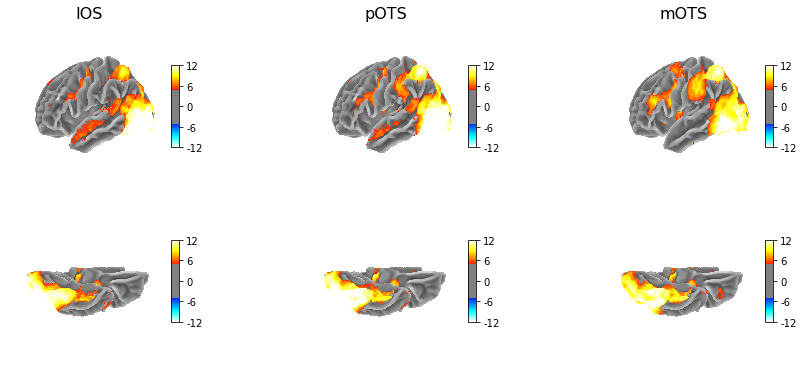

In [136]:
# create Figure
r_fig, r_axes = plt.subplots(2,len(roi_names),figsize=(14,5),sharey=True,subplot_kw={'projection': '3d'})
r_fig.tight_layout()

for roi_i in range(len(roi_names)):
    cur_roi_map = roi_maps[:,:,roi_i]
    t_vals, p_vals = stats.ttest_1samp(cur_roi_map, 0)
    z_vals = stats.norm.isf(p_vals)
    
    # Plot
    plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=z_vals,
    hemi='left', threshold = 5, vmax=12, view='lateral', colorbar=True,axes=r_axes[0,roi_i],
    bg_map=fsaverage['curv_left'],title=None)
    r_axes[0,roi_i].set_title(roi_short_names[roi_i],fontsize=16)

    plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=z_vals,
    hemi='left', threshold = 5, vmax=12, view='ventral', colorbar=True,axes=r_axes[1,roi_i],
    bg_map=fsaverage['curv_left'],title=None)

#fig.suptitle('z scores' + ' ' + task,fontsize =20)

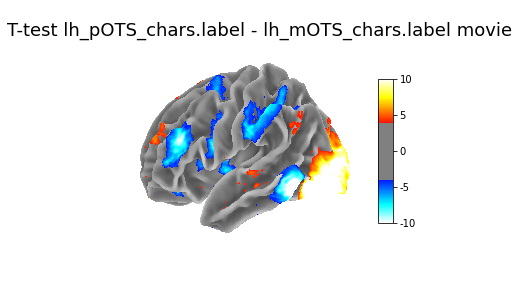

In [138]:
# Run a dependent sample t-test between the two maps
roi1_ind = roi_short_names.index('pOTS')
roi2_ind = roi_short_names.index('mOTS')
if faces = True:
    roi1_ind = roi_short_names.index('pFus')
    roi2_ind = roi_short_names.index('mFus')
ttest_res = stats.ttest_rel(roi_maps[:,:,roi1_ind],roi_maps[:,:,roi2_ind],nan_policy='omit')
# Plot t-test result as a map
plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=ttest_res.statistic,
hemi='left', threshold = 4, vmax=10, view='lateral', colorbar=True,
bg_map=fsaverage['curv_left'], title='T-test '+ roi_names[roi1_ind] + ' - ' + roi_names[roi2_ind] + ' ' + task, output_file = None)
print()

## Compare rest data and movie data
##### Do seed ROIs have different connectivity patterns when subjects are watching a movie?

In [65]:
# load each roi's rest data
# load each roi's movie data
# loop through rois

# First we load all seed-based connectivity maps
# THIS SHOULD BE ONLY FOR THE SUBJECTS THAT HAVE BOTH data! 
# Filter files according to data frame. 
rest_maps = np.zeros(shape = (sub_count,white_left[0].shape[0],len(roi_names)))
movie_maps = np.zeros(shape = (sub_count,white_left[0].shape[0],len(roi_names)))
#roi_map shape is subjects * vertices * seed

# Load all data into one array
for roi_i in range(len(roi_names)):
    cur_roi_path = datadir + 'GroupMap_task-rest_' + roi_names[roi_i] + '_N' + str(sub_count)+ '.npy'
    cur_roi_map = np.load(cur_roi_path)
    rest_maps[:,:,roi_i] = cur_roi_map
    cur_roi_path = datadir + 'GroupMap_task-movie_' + roi_names[roi_i] + '_N' + str(sub_count)+ '.npy'
    cur_roi_map = np.load(cur_roi_path)
    movie_maps[:,:,roi_i] = cur_roi_map
    

In [10]:
rest_file = projectdir+ 'subs_preprocessed_onlyrest_meanFD05_SNR15_FD05_90_WIAT.csv'
movie_file = projectdir+ 'subs_preprocessed_onlymovie_meanFD05_SNR15_FD05_90_WIAT.csv'

rest_data = pd.read_csv(rest_file)
movie_data = pd.read_csv(movie_file)

In [19]:
# We can merge into one data frame but then we wont keep the indices to filter
# 
#both_data = pd.merge(rest_data,movie_data )
rest_keep = rest_data.loc[rest_data['existsMovieDM'] == 1]
rest_keep = meanFD_movieDM

In [27]:
my_filter = np.logical_and(rest_data['existsMovieDM'] == 1, rest_data['meanFD_movieDM'] < 0.5, rest_data['SNR_movieDM'] > 1.5)

In [35]:
# filter movie dataframe by rest
my_filter_2 = (movie_data['meanFD_run1'] <0.5) & (movie_data['meanFD_run2'] <0.5) & (movie_data['SNR_run1'] >1.5) & (movie_data['SNR_run2'] >1.5)
sum(my_filter_2)

100

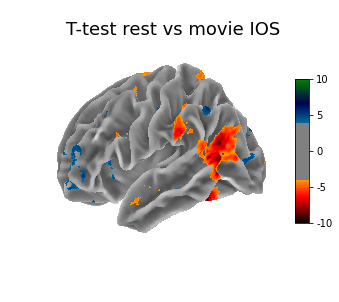

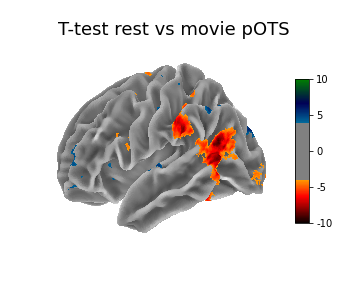

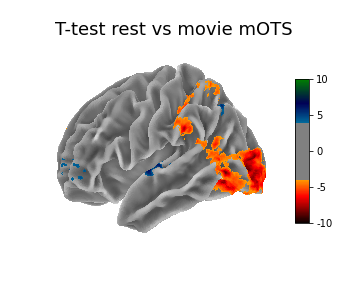

In [70]:
# Now for each ROI compare the maps
for roi_i in range(len(roi_names)):
    
    ttest_res = stats.ttest_rel(rest_maps[:,:,roi_i],movie_maps[:,:,roi_i],nan_policy='omit')
    # Plot t-test result as a map
    plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=ttest_res.statistic,
    hemi='left', threshold = 4, vmax=10, view='lateral', colorbar=True,cmap='ocean_hot_r',
    bg_map=fsaverage['curv_left'], title='T-test rest vs movie '+ roi_short_names[roi_i] + ' ', output_file = None)
    print()

# Whole brain analysis
#### Look for correlations with behavior across the entire surface

In [7]:
myVar = 'WIAT_Word_Stnd'
myData = sub_data[myVar]
behav_corr_mat = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
behav_pval_mat = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
behav_nancount = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
for roi_id in range(len(roi_names)):
    for vertex_id in range(roi_maps.shape[1]):
        brain_data = roi_maps[:,vertex_id, roi_id]
        nanvals = np.logical_or(np.isnan(brain_data), np.isnan(myData))
        rval,pval = stats.pearsonr(brain_data[~nanvals],myData[~nanvals])
        behav_corr_mat[vertex_id, roi_id] = rval
        behav_pval_mat[vertex_id, roi_id] = pval
        behav_nancount[vertex_id, roi_id] = np.sum(nanvals)

In [2]:
result = stats.linregress(brain_data[~nanvals],myData[~nanvals])

NameError: name 'stats' is not defined

In [10]:
# find value corresponding to a specific p value- trial and error
# myval=0.217 --> p = 0.00108
# myval=0.17 --> p = 0.0108

myval=0.17
n = sub_count
dist = stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
p = 2*dist.cdf(-abs(myval))
print('N= ' + str(n))
print('pval = ' + str(p))

N= 224
pval = 0.010813427601427485


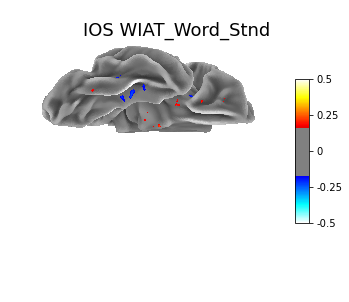

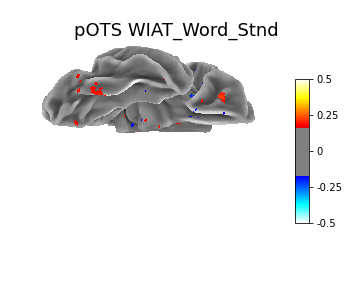

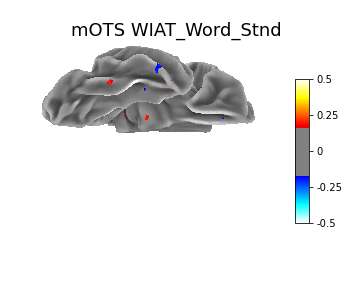

In [12]:
for roi_i in range(len(roi_names)):
    plotting.plot_surf_stat_map(fsaverage['white_'+ hemi], stat_map=behav_corr_mat[:,roi_i],
    hemi=hemi, threshold =myval, vmax=0.5, view='lateral', colorbar=True,
    bg_map=fsaverage['curv_'+hemi], title=roi_short_names[roi_i] + ' ' + myVar,output_file = None)
    print()

In [18]:
myVar = 'Age'
myData = sub_data[myVar]
behav_corr_mat = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
behav_pval_mat = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
behav_nancount = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
for roi_id in range(len(roi_names)):
    for vertex_id in range(roi_maps.shape[1]):
        brain_data = roi_maps[:,vertex_id, roi_id]
        nanvals = np.isnan(brain_data)
        rval,pval = stats.pearsonr(brain_data[~nanvals],myData[~nanvals])
        behav_corr_mat[vertex_id, roi_id] = rval
        behav_pval_mat[vertex_id, roi_id] = pval
        behav_nancount[vertex_id, roi_id] = np.sum(nanvals)

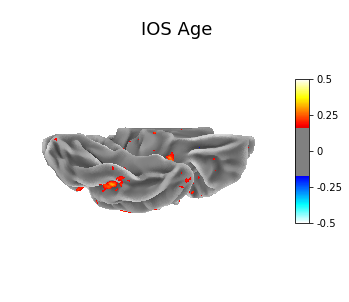

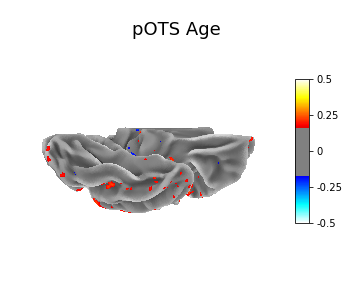

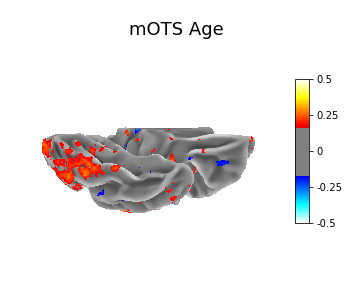

In [19]:
for roi_i in range(len(roi_names)):
    plotting.plot_surf_stat_map(fsaverage['white_'+ hemi], stat_map=behav_corr_mat[:,roi_i],
    hemi=hemi, threshold = myval, vmax=0.5, view='ventral', colorbar=True,
    bg_map=fsaverage['curv_'+ hemi], title=roi_short_names[roi_i] + ' ' + myVar,output_file = None)
    print()

In [36]:
# Test what happens when I exclude two behavioral outliers

myVar = 'WIAT_Word_Stnd'
myData = sub_data[myVar]
# Filter outliers? 
myfilter = myData > (np.nanmean(myData) - 2.5 * np.nanstd(myData))
myData = myData[myfilter]
    
behav_corr_mat = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
behav_pval_mat = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
behav_nancount = np.empty(shape=(white_left[0].shape[0],len(roi_names)))
for roi_id in range(len(roi_names)):
    for vertex_id in range(roi_maps.shape[1]):
        brain_data = roi_maps[:,vertex_id, roi_id]
        brain_data = brain_data[myfilter]
        nanvals = np.logical_or(np.isnan(brain_data), np.isnan(myData))
        rval,pval = stats.pearsonr(brain_data[~nanvals],myData[~nanvals])
        behav_corr_mat[vertex_id, roi_id] = rval
        behav_pval_mat[vertex_id, roi_id] = pval
        behav_nancount[vertex_id, roi_id] = np.sum(nanvals)

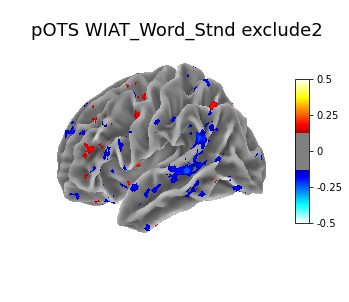

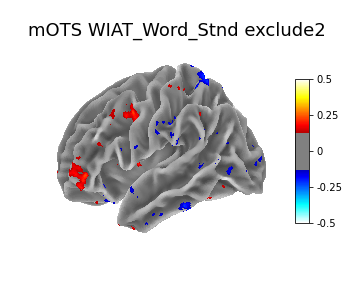

In [43]:
for roi_i in range(len(roi_names)):
    plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=behav_corr_mat[:,roi_i],
    hemi='left', threshold = 0.13, vmax=0.5, view='lateral', colorbar=True,
    bg_map=fsaverage['curv_left'], title=roi_short_names[roi_i] + ' ' + myVar + ' exclude2',output_file = None)
    print()

### Other useful syntax and things I tried

In [83]:
print(nilearn.__file__)
print(pd.__file__)

/home/users/mayay/.local/lib/python3.9/site-packages/nilearn/__init__.py
/home/users/mayay/.local/lib/python3.9/site-packages/pandas/__init__.py


In [47]:
print(nilearn.__version__)

0.9.1


In [133]:
print(sns.__version__)

0.11.2


In [22]:
import matplotlib
print(matplotlib.__version__)

3.5.0


In [16]:
from atlasreader import create_output
file_name = '/scratch/groups/jyeatman/HBN_FC/volume/analyses/rest_N_231_ttest.nii.gz'
create_output(file_name, cluster_extent=300)

KeyboardInterrupt: 